# Image tiling for annotation

#### Meanings of arguments
- ```-ratioheight``` : proportion of tile  w.r.t height of image. Example 0.5 means dividing the image in two bands w.r.t height.
- ```-ratiowidth``` : proportion of tile w.r.t to width of image. Example 1.0 means the width of the tile is the same as the image.
- ```-overlapfactor``` : percentage of overlap. It should be less than 1.
- ```-rmheight``` : percentage of height to remove or crop at bottom and top
- ```-rmwidth``` : percentage of width to remove or crop on each side of the image
- ```-pattern``` : "**/*.JPG" will get all .JPG images in directory and subdirectories. On windows it will get both .JPG and .jpg. On unix it will only get .JPG images


In [ ]:
# New script for tiling data
# images_to_tile = r"D:\PhD\Data per camp\Extra training data\savmap_dataset_v2\raw_data\images"
# destination_directory = r"D:\PhD\Data per camp\Extra training data\savmap_dataset_v2\raw_data\images-tiled"
!python ../../HerdNet/tools/patcher.py "D:\PhD\Data per camp\Wet season\Kapiri\Camp 3\DJI_202402051048_003_KapiriCamp3" 0 0 0 -overlapfactor 0.1  -ratiowidth 0.5 -ratioheight 0.5 -rmheight 0 -rmwidth 0 -dest "D:\PhD\Data per camp\Wet season\Kapiri\Camp 3\DJI_202402051048_003_KapiriCamp3 - tiled" -pattern "**/*.JPG"

: 

# Pre-annotating data for Labelstudio

In [ ]:
from dotenv import load_dotenv
load_dotenv('../.env')

from datalabeling.annotator import Annotator
import os
from pathlib import Path
import torch
from tqdm import tqdm

### Creating a JSON file to be uuploaded to Label studio

In [ ]:
# Example
# provide correct alias, "pt", "onnx"
alias = "last" # the aliases are found in mlflow tracker UI, use "last-1" to use the previous model
name = "obb-detector" # detector, "obb-detector"
handler = Annotator(mlflow_model_alias=alias,
                    mlflow_model_name=name,
                    is_yolo_obb= name.strip() == "obb-detector",
                    # dotenv_path="../.env"
                    )
path_img_dir=r"D:\PhD\Africa Parks\Liuwa aerial survey_ALL\CENSUS 2019\DAY 2 CENSUS 2019_CONVERTED\AP 2019 day 2 - tiled"
root="D:\\"
save_json_path = os.path.join(Path(path_img_dir).parent, f"{Path(path_img_dir).name}_preannotation_label-studio.json")

# build and saves json
directory_preds = handler.build_upload_json(path_img_dir=path_img_dir,
                                            root=root,
                                            save_json_path=save_json_path,
                                            pattern="**/*.JPG")

### Pre-annotating an existing project using Label studio API
It seems that it will not work well (i.e. filtering) with older projects created prior to Label studio software update.
It is the **recommended way of pre-annotating data in Labelstudio**.

In [ ]:
# provide correct alias, "pt", "onnx"
aliases = ["version11",]
project_id = 40 # insert correct project_id by loooking at the url
for alias in aliases:
    name = "obb-detector" # detector, "obb-detector"
    handler = Annotator(mlflow_model_alias=alias,
                        mlflow_model_name=name,
                        confidence_threshold=0.15,
                        is_yolo_obb=name.strip() == "obb-detector",
                        dotenv_path="../.env")
    handler.upload_predictions(project_id=project_id)

**Before running the script below, make sure you have exported the annotations so you CAN revert back!!!**
- CLEANING ANNOTATIONS that have been mistakenly saved with label="wildlife"

In [ ]:
#  Cleaning annotations - NO WAY BACK
name = "obb-detector"
handler = Annotator(mlflow_model_alias="version6",
                        mlflow_model_name=name,
                        confidence_threshold=0.25,
                        is_yolo_obb=name.strip() == "obb-detector",
                        dotenv_path="../.env")

# Select project
project_id = 88
project = handler.labelstudio_client.get_project(id=project_id)

# Delete annotations saved with label "wildlife" assigned by the predictor
tasks = project.get_tasks()
for task in tqdm(tasks,desc="correcting annotations"):
        task_id = task['id']
        img_url = task['data']['image']

        if len(task["annotations"][0]['result'])>1:
            results_to_keep = []
            annot_id = task["annotations"][0]["id"]
            for annot in task['annotations'][0]['result']:
                if annot['value']['rectanglelabels'][0] != 'wildlife':
                    results_to_keep.append(annot)
                    # print(annot['value'],annot['id'],end="\n")
            # print(f"Updating annotations {annot_id} from task {task_id}.")
            # print(results_to_keep)
            project.update_annotation(annot_id,result=results_to_keep)

In [ ]:
len(task['annotations']), len(task['annotations'][0]['result']), task['id'], task["annotations"][0]["id"]

In [ ]:
task['annotations'][0]['result'][0] #['value']['rectanglelabels']

In [ ]:
results_to_keep = []
for annot in task['annotations'][0]['result']:
    if annot['value']['rectanglelabels'][0] != 'wildlife':
        results_to_keep.append(annot)
        print(annot['value'],annot['id'],end="\n")

In [ ]:
results_to_keep

In [ ]:
project.update_annotation(annotation_id=...,)

To speed up inference on intel, make changes inn ultralytics/nn/autobackend.py:
```
- device_name = "AUTO:NPU,GPU,CPU" # CPU, GPU, NPU, AUTO,"AUTO:GPU,NPU"
- inference_mode = "LATENCY" # OpenVINO inference modes are 'LATENCY', 'THROUGHPUT' (not recommended), or 'CUMULATIVE_THROUGHPUT'
- LOGGER.info(f"Using OpenVINO {inference_mode} mode for inference...")
- ov_compiled_model = core.compile_model(
                ov_model,
                device_name=device_name,  # AUTO selects best available device, do not modify
                config={"PERFORMANCE_HINT": inference_mode,
                        "CACHE_DIR": os.environ["OPENVINO_CACHE_MODEL"]}, # make sure to set environment variable
            )
```

In [ ]:
# using path_to_weights
# go to ultralytics.nn.autobackend to modify ov_compiled device to "AUTO:NPU,GPU,CPU"

use_sliding_window=True

handler = Annotator(path_to_weights=r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best_openvino_model",
                    is_yolo_obb=True,
                    tilesize=1280,
                    overlapratio=0.1,
                    use_sliding_window=use_sliding_window,
                    confidence_threshold=0.5,
                    device="NPU", # "cpu", "cuda"
                    tag_to_append=f"-sahi:{use_sliding_window}",
                    dotenv_path="../.env")

project_id = 3 # insert correct project_id by loooking at the url
top_n=10
handler.upload_predictions(project_id=project_id,top_n=top_n)

In [ ]:
from label_studio_ml.utils import get_local_path
from urllib.parse import unquote, quote
import os
path = unquote("/data/local-files/?d=savmap_dataset_v2%5Cimages_splits%5C003a34ee6b7841e6851b8fe511ebe102_0.JPG")
get_local_path(path,download_resources=False)#,os.path.exists(get_local_path(path))

# Inference with Sahi

In [ ]:
from ultralytics import YOLO
from PIL import Image
import time
import numpy as np
from datalabeling.annotator import Detector
from dotenv import load_dotenv

In [ ]:
# load env variable, loads model cache location!!
load_dotenv('../.env')

In [ ]:
IMAGE_PATH = r"D:\savmap_dataset_v2\images_splits\00a033fefe644429a1e0fcffe88f8b39_1.JPG"

## Optimizing with Openvino

To speed up inference on intel, make changes inn ultralytics/nn/autobackend.py:
```
- device_name = "AUTO:NPU,GPU,CPU" # CPU, GPU, NPU, AUTO,"AUTO:GPU,NPU"
- inference_mode = "LATENCY" # OpenVINO inference modes are 'LATENCY', 'THROUGHPUT' (not recommended), or 'CUMULATIVE_THROUGHPUT'
- LOGGER.info(f"Using OpenVINO {inference_mode} mode for inference...")
- ov_compiled_model = core.compile_model(
                ov_model,
                device_name=device_name,  # AUTO selects best available device, do not modify
                config={"PERFORMANCE_HINT": inference_mode,
                        "CACHE_DIR": os.environ["OPENVINO_CACHE_MODEL"]}, # make sure to set environment variable
            )
```

In [ ]:
# Define detector
# to speed up inference on intel, make
model = Detector(path_to_weights=r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best_openvino_model",
                confidence_threshold=0.1,
                overlap_ratio=0.1,
                tilesize=1280,
                device='CPU',
                use_sliding_window=False,
                is_yolo_obb=True)

In [ ]:
image = Image.open(IMAGE_PATH)

while True:
    start_time = time.perf_counter()
    print(model.predict(image,return_coco=True,nms_iou=0.5))
    end_time = time.perf_counter()
    print(f"Device took {end_time-start_time:.2f} seconds.")

    break

In [ ]:
# inference with openvino
import openvino as ov
import openvino.properties.hint as hints
import torch
import torchvision.transforms as F
from ultralytics.utils import DEFAULT_CFG
from ultralytics.cfg import get_cfg
from ultralytics.data.converter import coco80_to_coco91_class

# load validator
args = get_cfg(cfg=DEFAULT_CFG)
det_model = YOLO(r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best.pt")
det_validator = det_model.task_map[det_model.task]["validator"](args=args)
det_validator.is_coco = True
det_validator.class_map = coco80_to_coco91_class()
det_validator.names = det_model.model.names
det_validator.metrics.names = det_validator.names
det_validator.nc = det_model.model.model[-1].nc
det_validator.stride = 32
args = get_cfg(cfg=DEFAULT_CFG)
det_model = YOLO(r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best.pt")

core = ov.Core()
det_model_path = r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best_openvino_model\best.xml"
det_ov_model = core.read_model(det_model_path)

device = "AUTO:NPU,GPU" # CPU, NPU, GPU "AUTO:NPU,GPU,CPU" 

print("Available core devices: ",core.available_devices)

# reshaping for batch prediction
input_layer = det_ov_model.input(0)
output_layer = det_ov_model.output(0)
new_shape = ov.PartialShape([1, 3, 1280, 1280])
det_ov_model.reshape({input_layer.any_name: new_shape})

ov_config = {hints.performance_mode: hints.PerformanceMode.THROUGHPUT,
             "CACHE_DIR": '../models/model_cache'}

if ("GPU" in core.available_devices) and device=="GPU":
    ov_config["GPU_DISABLE_WINOGRAD_CONVOLUTION"] = "YES"
det_compiled_model = core.compile_model(det_ov_model, device, ov_config)

def infer(image):
    image = det_validator.preprocess({"img":image,"batch_idx":torch.Tensor([0]),
                                      "cls":torch.Tensor([0]),
                                      "bboxes":torch.Tensor([0.,0.,0.,0.])})["img"]
    results = det_compiled_model(image)
    preds = torch.from_numpy(results[det_compiled_model.output(0)])
    return det_validator.postprocess(preds) #torch.from_numpy(result[0])

In [ ]:
# image = Image.open(IMAGE_PATH)
# image = F.PILToTensor()(image)[None,:,:1280,:1280]
# infer(image)

In [ ]:
# inference with pt
# model = YOLO(r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best.pt",task='obb')

In [ ]:
# rescaling input images
# model(image/255.)

In [ ]:
# inference with openvino
# model_vino = YOLO(r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best_openvino_model",task='obb')
# model_vino(image/255.)

In [ ]:
# sahi_model_obb = Detector(path_to_weights=r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best_openvino_model",
#                     confidence_threshold=0.6,
#                     overlap_ratio=0.1,
#                     tilesize=640,
#                     is_yolo_obb=True)

In [ ]:
# image_path = r"D:\savmap_dataset_v2\images\0d1ba3c424ad4414ac37dbd0c93460ea.JPG"
# image = Image.open(image_path)
# print(image.size)

In [ ]:
# result = sahi_model_obb.predict(image,False)

In [ ]:
# result
# result.export_visuals('../.tmp')

## Sahi inference calibration

In [ ]:
from itertools import product

In [ ]:
# hyperparams
overlap_ratios = [0.1,0.2,0.3]
tilesizes = [640,2*640,3*640]
imgsz = [640,2*640,3*640]

for ratio, tilesize, image_size in product(overlap_ratios,tilesizes,imgsz):
    print(ratio,tilesize,image_size)
    # Define detector
    # to speed up inference on intel, make
    model = Detector(path_to_weights=r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best_openvino_model",
                    confidence_threshold=0.1,
                    overlap_ratio=0.1,
                    tilesize=2000,
                    imgsz=1280,
                    device='CPU',
                    use_sliding_window=True,
                    is_yolo_obb=True)
    
    #TODO


# YOLO data_config.yaml 

In [ ]:
import yaml
import json
from datalabeling.arguments import Arguments
import os
import pandas as pd

In [ ]:
# load yaml
with open(r"D:\PhD\Data per camp\DetectionDataset\hard_samples\train_ratio_20-seed_41.yaml",'r') as file:
    yolo_config = yaml.load(file,Loader=yaml.FullLoader)
yolo_config

In [ ]:
pd.read_csv(os.path.join(yolo_config["path"],yolo_config['train']),header=None,names=['paths'])['paths'].to_list()[:]

In [ ]:
# load label mapping
args = Arguments()
with open(r"D:\PhD\Data per camp\IdentificationDataset\label_mapping.json",'r') as file:
    label_map = json.load(file)
names = [p['name'] for p in label_map if p['name'] not in args.discard_labels ]
label_map = dict(zip(range(len(names)),names))
label_map

In [ ]:
from label_studio_sdk import Client
from dotenv import load_dotenv
load_dotenv('../.env')

def get_ls_parsed_config(ls_json_path:str):

    ls_client = None
    if ls_client is None:
        # Connect to the Label Studio API and check the connection
        LABEL_STUDIO_URL = os.getenv('LABEL_STUDIO_URL')
        API_KEY = os.getenv("LABEL_STUDIO_API_KEY")
        labelstudio_client = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)

    with open(ls_json_path,'r') as f:
        ls_annotation = json.load(fp=f)
    ids = set([annot['project'] for annot in ls_annotation])
    assert len(ids)==1, "annotations come from different project. Not allowed!"
    project_id = ids.pop()
    project = labelstudio_client.get_project(id=project_id)

    return project.parsed_label_config


In [ ]:
yolo_config.update({'names':label_map,'nc':len(label_map)})
yolo_config

In [ ]:
with open(r"D:\PhD\Data per camp\IdentificationDataset\data_config.yaml",'w') as file:
    yaml.dump(yolo_config,file,default_flow_style=False, sort_keys=False)

# Dataset distribution

## Visualize distribution per annotation project

In [ ]:
from datalabeling.dataset import convert_json_annotations_to_coco, load_coco_annotations
from pathlib import Path
import json
import pandas as pd
from collections import Counter
from dotenv import load_dotenv
from label_studio_sdk import Client
# from itertools import chain
import traceback
import os

In [ ]:
dotenv_path=r"..\.env"
load_dotenv(dotenv_path=dotenv_path)
# Connect to the Label Studio API and check the connection
LABEL_STUDIO_URL = os.getenv('LABEL_STUDIO_URL')
API_KEY = os.getenv("LABEL_STUDIO_API_KEY")
labelstudio_client = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)

In [ ]:

def get_project_stats(project_id:int,annotator_id = 0):
    
    project = labelstudio_client.get_project(id=project_id)
    num_images = dict()
    # Iterating 
    tasks = project.get_tasks()
     # because there is
    labels = []

    for task in tasks:
        try:
            result = task['annotations'][annotator_id]['result']
        except Exception as e:
            traceback.print_exc()
            continue

        img_labels = []
        for annot in result:
            img_labels = annot['value']['rectanglelabels'] + img_labels
        labels = labels + img_labels
        # update stats holder
        for label in set(img_labels):
            try:
                num_images[label] += 1
            except:
                num_images[label] = 1

    stats = {f"{k}":labels.count(k) for k in set(labels)}
    print("Number of instances for each label is:\n",stats,end="\n\n")
    print("Number of images for each label is:\n",num_images)

    return stats, num_images

# get stats
for project_id in [93,]:
    get_project_stats(project_id)

In [ ]:
ls_dir = r"D:\PhD\Data per camp\Exported annotations and labels\Wet season - Rep 1\all\labelstudio"
dest_dir = Path(ls_dir).with_name("coco-format")
save_excel_path = Path(ls_dir).with_name("stats.xlsx")

# Uncomment to run if needed
# convert_json_annotations_to_coco(input_dir=ls_dir,
#                                  dest_dir_coco=str(dest_dir),
#                                  ls_client=labelstudio_client,
#                                  parse_ls_config=True)

In [ ]:
coco_annotations_dict = load_coco_annotations(dest_dir)
coco_annotations_dict

In [ ]:
def get_labels_count(coco_annotation:dict):

    result = Counter([annot['category_id'] for annot in coco_annotation['annotations']])

    label_map = {cat['id']:cat['name'] for cat in coco_annotation['categories']}

    result = {label_map[k]:v for k,v in result.items()}

    return result

label_stats = dict()

for img_dir,coco_path in coco_annotations_dict.items():

    with open(coco_path,'r') as f:
        coco_annotation = json.load(fp=f)
    
    label_stats[img_dir] = get_labels_count(coco_annotation)

label_stats = pd.DataFrame.from_dict(label_stats,orient='index').fillna(0)

In [ ]:
label_stats

In [ ]:
# uncomment to save
label_stats.to_excel(save_excel_path)

## Visualize splits' distribution

In [1]:
import yaml
import pandas as pd
import os
from pathlib import Path

In [ ]:
# load yaml
with open(r"D:\PhD\Data per camp\Extra training data\WAID\data_config.yaml",'r') as file:
    yolo_config = yaml.load(file,Loader=yaml.FullLoader)
yolo_config

In [ ]:
label_map = yolo_config['names']

In [ ]:
split = 'train'

path_dataset = os.path.join(yolo_config['path'],yolo_config[split][0])
path_dataset = path_dataset.replace('images','labels')

path_dataset

In [ ]:
labels = list()

for txtfile in Path(path_dataset).glob("*.txt"):

    df = pd.read_csv(txtfile,sep=" ",names = ['class','x','y','w','h'] )
    df['class'] = df['class'].astype(int)    
    df['image'] = txtfile.stem
    labels.append(df)


In [ ]:
df = pd.concat(labels,axis=0)
df['class'] = df['class'].map(label_map)

In [ ]:
images_per_class = dict()
for cls in df['class'].unique():
    num_imge = df.loc[df['class'] == cls,'image'].unique().shape[0]
    images_per_class[cls] = num_imge

In [ ]:
print("Split:", split)
print(images_per_class)

In [ ]:
print('Split:',split)
print(df['class'].value_counts())

In [ ]:
df['class'].value_counts().plot(kind='bar',figsize=(10,5),logy=True,title=f"{split} label distribution")

# Computing metrics on Validation set

### YOLO or ultralytics models

In [ ]:
from ultralytics import YOLO
# from pathlib import Path
from datalabeling.train import remove_label_cache

In [ ]:
# [IMPORTANT] Run this cell to convert the datasets to yolo format
!python  ../tools/build_dataset.py --obb-to-yolo --data-config-yaml "..\data\dataset_identification.yaml" --skip
!python  ../tools/build_dataset.py --obb-to-yolo --data-config-yaml "..\data\dataset_identification-detection.yaml" --skip

: 

In [ ]:
# Getting results for yolov12s : Detection and Identification
paths = ["...", # Identification model weights
         "../runs/mlflow/140168774036374062/a59eda79d9444ff4befc561ac21da6b4/artifacts/weights/best.pt" # Detection model weights
        ]

dataconfigs = [
                # r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification.yaml",
               r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification-detection.yaml"
              ]

imgsz = 800
iou_threshold=0.45
conf_threshold=0.235
splits = [
            # "val", 
          "test",
          ]

# remove label.cache files
for dataconfig in dataconfigs:
    remove_label_cache(data_config_yaml=dataconfig)

for split in splits:
    for path,dataconfig in zip(paths,dataconfigs):
        print("\n",'-'*20,split,'-'*20)
        model = YOLO(path)
        model.info()
        
        # Customize validation settings
        validation_results = model.val(data=dataconfig,
                                        imgsz=imgsz,
                                        batch=64,
                                        split=split,
                                        conf=conf_threshold,
                                        iou=iou_threshold,
                                        device="cuda"
                                    )

In [13]:
# Getting results for yolov5s : Detection and Identification
paths = ["../runs/mlflow/140168774036374062/87718ce84ce04dacac6ab8c92328eae7/artifacts/weights/best.pt", # Identification model weights
         "../runs/mlflow/140168774036374062/e5e3bf93d34f48f1bb7d0a648530bb45/artifacts/weights/best.pt" # Detection model weights
        ]

dataconfigs = [r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification.yaml",
               r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification-detection.yaml"
              ]

imgsz = 800
iou_threshold=0.45
conf_threshold=0.235
splits = [
            # "val", 
          "test",
          ]

# remove label.cache files
for dataconfig in dataconfigs:
    remove_label_cache(data_config_yaml=dataconfig)

for split in splits:
    for path,dataconfig in zip(paths,dataconfigs):
        print("\n",'-'*20,split,'-'*20)
        model = YOLO(path)
        model.info()
        
        # Customize validation settings
        validation_results = model.val(data=dataconfig,
                                        imgsz=imgsz,
                                        batch=64,
                                        split=split,
                                        conf=conf_threshold,
                                        iou=iou_threshold,
                                        device="cuda"
                                    )

D:\PhD\Data per camp\IdentificationDataset\train\images\../labels.cache does not exist.
Removing: D:\PhD\Data per camp\IdentificationDataset\val\images\../labels.cache
D:\PhD\Data per camp\IdentificationDataset\test\images\../labels.cache does not exist.
D:\PhD\Data per camp\DetectionDataset\Identification-split\train\images\../labels.cache does not exist.
Removing: D:\PhD\Data per camp\DetectionDataset\Identification-split\val\images\../labels.cache
D:\PhD\Data per camp\DetectionDataset\Identification-split\test\images\../labels.cache does not exist.

 -------------------- test --------------------
YOLOv5s summary: 262 layers, 9,124,514 parameters, 0 gradients, 24.1 GFLOPs
Ultralytics 8.3.27  Python-3.12.2 torch-2.2.2+cu118 CUDA:0 (NVIDIA RTX A5000, 24563MiB)
YOLOv5s summary (fused): 193 layers, 9,113,858 parameters, 0 gradients, 23.8 GFLOPs


val: Scanning D:\PhD\Data per camp\IdentificationDataset\test\labels... 1061 images, 21220 backgrounds, 0 corrupt: 100%|██████████| 22281/22281 [00:12<00:00, 1748.40it/s]


val: New cache created: D:\PhD\Data per camp\IdentificationDataset\test\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 349/349 [01:29<00:00,  3.92it/s]


                   all      22281       2585      0.487      0.406      0.443      0.255
               buffalo         67        283      0.619      0.636      0.628      0.257
                impala        170        515      0.816      0.353      0.595      0.376
                 nyala        123        259      0.216      0.147      0.173     0.0992
              nyala(m)         55         55      0.317      0.345        0.4      0.247
                  roan        138        205      0.128      0.307      0.106     0.0621
                 sable        532       1268      0.826      0.645      0.759       0.49
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs\detect\val15

 -------------------- test --------------------
YOLOv5s summary: 262 layers, 9,122,579 parameters, 0 gradients, 24.0 GFLOPs
Ultralytics 8.3.27  Python-3.12.2 torch-2.2.2+cu118 CUDA:0 (NVIDIA RTX A5000, 24563MiB)
YOLOv5s summary (fused): 193 layers, 9,111,923 

val: Scanning D:\PhD\Data per camp\DetectionDataset\Identification-split\test\labels... 1424 images, 28480 backgrounds, 0 corrupt: 100%|██████████| 29904/29904 [00:16<00:00, 1771.20it/s]


val: New cache created: D:\PhD\Data per camp\DetectionDataset\Identification-split\test\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 468/468 [02:00<00:00,  3.89it/s]


                   all      29904       4034       0.84       0.72      0.809      0.476
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs\detect\val16


In [15]:
# [IMPORTANT] Run this cell to convert the datasets to obb format
!python  ../tools/build_dataset.py --yolo-to-obb --data-config-yaml "..\data\dataset_identification.yaml" --skip
!python  ../tools/build_dataset.py --yolo-to-obb --data-config-yaml "..\data\dataset_identification-detection.yaml" --skip

03/02/2025 12:22:01 - INFO - __main__ -   Converting D:\PhD\Data per camp\IdentificationDataset\train\labels: yolo->obb

yolo->obb: 0it [00:00, ?it/s]
yolo->obb: 12it [00:00, 119.58it/s]
yolo->obb: 26it [00:00, 128.29it/s]
yolo->obb: 40it [00:00, 129.84it/s]
yolo->obb: 54it [00:00, 130.55it/s]
yolo->obb: 68it [00:00, 131.84it/s]
yolo->obb: 82it [00:00, 132.62it/s]
yolo->obb: 96it [00:00, 133.50it/s]
yolo->obb: 110it [00:00, 135.36it/s]
yolo->obb: 124it [00:00, 134.57it/s]
yolo->obb: 138it [00:01, 134.04it/s]
yolo->obb: 152it [00:01, 133.25it/s]
yolo->obb: 166it [00:01, 134.30it/s]
yolo->obb: 180it [00:01, 134.65it/s]
yolo->obb: 194it [00:01, 134.11it/s]
yolo->obb: 208it [00:01, 132.96it/s]
yolo->obb: 222it [00:01, 134.05it/s]
yolo->obb: 236it [00:01, 133.69it/s]
yolo->obb: 250it [00:01, 134.22it/s]
yolo->obb: 264it [00:01, 132.66it/s]
yolo->obb: 278it [00:02, 132.35it/s]
yolo->obb: 292it [00:02, 131.75it/s]
yolo->obb: 306it [00:02, 131.34it/s]
yolo->obb: 320it [00:02, 132.55it/s]
yolo-

In [17]:
# Load yolov11s-obb
paths = ["../runs/mlflow/140168774036374062/34c709364c0e46dcb72c526de34a7fa4/artifacts/weights/best.pt", # Identification
         "../runs/mlflow/140168774036374062/f5b7124be14c4c89b8edd26bcf7a9a76/artifacts/weights/best.pt", # Detection
        ]


dataconfigs = [r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification.yaml",
               r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification-detection.yaml"
              ]

imgsz = 800
iou_threshold=0.45
conf_threshold=0.235
splits = [
        #   "val", 
          "test",
          ]

# remove label.cache files
for dataconfig in dataconfigs:
    remove_label_cache(data_config_yaml=dataconfig)

for split in splits:
    for path,dataconfig in zip(paths,dataconfigs):
        print("\n",'-'*20,split,'-'*20)
        model = YOLO(path)
        model.info()
        
        # Customize validation settings
        validation_results = model.val(data=dataconfig,
                                        imgsz=imgsz,
                                        batch=64,
                                        split=split,
                                        conf=conf_threshold,
                                        iou=iou_threshold,
                                        device="cuda"
                                    )

D:\PhD\Data per camp\IdentificationDataset\train\images\../labels.cache does not exist.
Removing: D:\PhD\Data per camp\IdentificationDataset\val\images\../labels.cache
D:\PhD\Data per camp\IdentificationDataset\test\images\../labels.cache does not exist.
D:\PhD\Data per camp\DetectionDataset\Identification-split\train\images\../labels.cache does not exist.
Removing: D:\PhD\Data per camp\DetectionDataset\Identification-split\val\images\../labels.cache
D:\PhD\Data per camp\DetectionDataset\Identification-split\test\images\../labels.cache does not exist.

 -------------------- test --------------------
YOLO11s-obb summary: 344 layers, 9,716,293 parameters, 0 gradients, 22.5 GFLOPs
Ultralytics 8.3.27  Python-3.12.2 torch-2.2.2+cu118 CUDA:0 (NVIDIA RTX A5000, 24563MiB)
YOLO11s-obb summary (fused): 257 layers, 9,701,109 parameters, 0 gradients, 22.3 GFLOPs


val: Scanning D:\PhD\Data per camp\IdentificationDataset\test\labels... 1061 images, 21220 backgrounds, 0 corrupt: 100%|██████████| 22281/22281 [00:04<00:00, 4930.04it/s]


val: New cache created: D:\PhD\Data per camp\IdentificationDataset\test\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 349/349 [01:45<00:00,  3.31it/s]


                   all      22281       2585      0.552      0.448      0.504      0.388
               buffalo         67        283      0.554      0.767       0.69      0.496
                impala        170        515      0.719      0.388      0.546      0.439
                 nyala        123        259      0.287      0.158      0.206       0.15
              nyala(m)         55         55      0.773      0.309      0.567      0.441
                  roan        138        205      0.182      0.312      0.197       0.14
                 sable        532       1268      0.798      0.753      0.817      0.658
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\obb\val12

 -------------------- test --------------------
YOLO11s-obb summary: 344 layers, 9,714,358 parameters, 0 gradients, 22.5 GFLOPs
Ultralytics 8.3.27  Python-3.12.2 torch-2.2.2+cu118 CUDA:0 (NVIDIA RTX A5000, 24563MiB)
YOLO11s-obb summary (fused): 257 layers, 9,699

val: Scanning D:\PhD\Data per camp\DetectionDataset\Identification-split\test\labels... 1424 images, 28480 backgrounds, 0 corrupt: 100%|██████████| 29904/29904 [00:06<00:00, 4663.45it/s]


val: New cache created: D:\PhD\Data per camp\DetectionDataset\Identification-split\test\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 468/468 [02:23<00:00,  3.27it/s]


                   all      29904       4034      0.867      0.752      0.844      0.651
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\obb\val13


In [ ]:
# Load yolov8s-obb
paths = [
         "../runs/mlflow/140168774036374062/b883bd2b31f94f29807ea3b94e8ff8fc/artifacts/weights/best.pt", # Identification
         "../runs/mlflow/140168774036374062/8a76c60253fc48788b5324096d035420/artifacts/weights/best.pt"  # Detection
        ]


dataconfigs = [
                r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification.yaml",
               r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification-detection.yaml"
              ]

imgsz = 800
iou_threshold=0.45
conf_threshold=0.235
splits = [
        #   "val", 
          "test",
          ]

# remove label.cache files
for dataconfig in dataconfigs:
    remove_label_cache(data_config_yaml=dataconfig)

for split in splits:
    for path,dataconfig in zip(paths,dataconfigs):
        print("\n",'-'*20,split,'-'*20)
        model = YOLO(path)
        model.info()
        
        # Customize validation settings
        validation_results = model.val(data=dataconfig,
                                        imgsz=imgsz,
                                        batch=64,
                                        split=split,
                                        conf=conf_threshold,
                                        iou=iou_threshold,
                                        device="cuda"
                                    )

D:\PhD\Data per camp\IdentificationDataset\train\images\../labels.cache does not exist.
Removing: D:\PhD\Data per camp\IdentificationDataset\val\images\../labels.cache
D:\PhD\Data per camp\IdentificationDataset\test\images\../labels.cache does not exist.
D:\PhD\Data per camp\DetectionDataset\Identification-split\train\images\../labels.cache does not exist.
Removing: D:\PhD\Data per camp\DetectionDataset\Identification-split\val\images\../labels.cache
D:\PhD\Data per camp\DetectionDataset\Identification-split\test\images\../labels.cache does not exist.

 -------------------- test --------------------
YOLOv8s-obb summary: 250 layers, 11,424,101 parameters, 0 gradients, 29.6 GFLOPs
Ultralytics 8.3.27  Python-3.12.2 torch-2.2.2+cu118 CUDA:0 (NVIDIA RTX A5000, 24563MiB)
YOLOv8s-obb summary (fused): 187 layers, 11,413,893 parameters, 0 gradients, 29.4 GFLOPs


val: Scanning D:\PhD\Data per camp\IdentificationDataset\test\labels... 1061 images, 21220 backgrounds, 0 corrupt: 100%|██████████| 22281/22281 [00:04<00:00, 5322.67it/s]


val: New cache created: D:\PhD\Data per camp\IdentificationDataset\test\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 349/349 [01:40<00:00,  3.48it/s]


                   all      22281       2585      0.475      0.421      0.441      0.324
               buffalo         67        283        0.5      0.753      0.607      0.405
                impala        170        515       0.77       0.26      0.515      0.408
                 nyala        123        259      0.104      0.124     0.0854     0.0666
              nyala(m)         55         55      0.576      0.345      0.502      0.336
                  roan        138        205       0.15      0.376      0.188      0.133
                 sable        532       1268       0.75      0.671       0.75      0.597
Speed: 0.2ms preprocess, 3.8ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\obb\val18

 -------------------- test --------------------
YOLOv8s-obb summary: 250 layers, 11,429,132 parameters, 0 gradients, 29.7 GFLOPs
Ultralytics 8.3.27  Python-3.12.2 torch-2.2.2+cu118 CUDA:0 (NVIDIA RTX A5000, 24563MiB)
YOLOv8s-obb summary (fused): 187 layers, 11,4

val: Scanning D:\PhD\Data per camp\DetectionDataset\Identification-split\test\labels... 1424 images, 28480 backgrounds, 0 corrupt: 100%|██████████| 29904/29904 [00:13<00:00, 2169.66it/s]


val: New cache created: D:\PhD\Data per camp\DetectionDataset\Identification-split\test\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 468/468 [02:17<00:00,  3.40it/s]


                   all      29904       4034      0.866      0.617      0.765      0.587
             Waterbuck       1424       4034      0.866      0.617      0.765      0.587
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\obb\val19


In [ ]:
# Compute predictions
from dotenv import load_dotenv
load_dotenv('../.env')

from datalabeling.annotator import Annotator

for alias in ["version9", "version6"]:
    print("-"*10,alias,end="\n\n")
    name = "obb-detector" # detector, "obb-detector"
    handler = Annotator(mlflow_model_alias=alias,
                            mlflow_model_name=name,
                            confidence_threshold=0.25,
                            is_yolo_obb=name.strip() == "obb-detector",
                            dotenv_path="../.env")

    yolo_model = handler.model.unwrap_python_model().detection_model.detection_model.model
    validation_results = yolo_model.val(data=r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_hn.yaml",
                                    imgsz=1280,
                                    batch=32,
                                    conf=0.25,
                                    iou=0.45,
                                    device="cuda"
                                )
    
    print(validation_results)

### Herdnet

In [ ]:
from datalabeling.train.herdnet import HerdnetData, HerdnetTrainer
from datalabeling.arguments import Arguments
import lightning as L
import os, yaml
from pathlib import Path
import torch
import random
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

: 

In [ ]:
# lowering matrix multiplication precision
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")

args = Arguments()
args.lr0 = 3e-4
args.epochs = 15
args.imgsz = 800
args.batchsize = 8
down_ratio = 2
args.data_config_yaml = r"D:\datalabeling\data\data_config.yaml"
args.path_weights = r"D:\datalabeling\models\20220329_HerdNet_Ennedi_dataset_2023.pth"

In [3]:
# Example: load Prediction images
with open(args.data_config_yaml, 'r') as file:
    data_config = yaml.load(file, Loader=yaml.FullLoader)

images_path = os.path.join(data_config['path'],data_config['test'][0])
images_path = list(Path(images_path).glob('*'))


# Data
datamodule = HerdnetData(data_config_yaml=args.data_config_yaml,
                            patch_size=args.imgsz,
                            batch_size=args.batchsize,
                            down_ratio=down_ratio,
                            train_empty_ratio=0.,
                            )


In [4]:
datamodule.setup('fit')

Getting groundtruths: 668it [00:01, 501.47it/s]0:00<?, ?it/s]
concatenating datasets: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Sampling 0 empty images.


Getting groundtruths: 1356it [00:02, 508.51it/s]:00<?, ?it/s]
concatenating datasets: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


In [66]:
img,targets = datamodule.val_dataset[0]

In [6]:
for batch in tqdm(datamodule.val_dataloader()):
    pass

100%|██████████| 170/170 [00:18<00:00,  9.38it/s]


In [7]:
batch

{'img': tensor([[[[-0.4226, -0.4226, -0.4226,  ..., -0.9705, -0.9020, -0.8335],
           [-0.4054, -0.4054, -0.4054,  ..., -0.9877, -0.9363, -0.8678],
           [-0.3883, -0.3883, -0.3883,  ..., -1.0048, -0.9705, -0.9192],
           ...,
           [-1.0733, -1.0904, -1.0904,  ..., -0.9192, -0.9192, -0.9192],
           [-1.0562, -1.0733, -1.0904,  ..., -0.9363, -0.9363, -0.9363],
           [-1.0048, -1.0219, -1.0390,  ..., -0.9534, -0.9534, -0.9534]],
 
          [[-0.2325, -0.2325, -0.2325,  ..., -0.7927, -0.7227, -0.6527],
           [-0.2150, -0.2150, -0.2150,  ..., -0.8102, -0.7577, -0.6877],
           [-0.1975, -0.1975, -0.1975,  ..., -0.8277, -0.7927, -0.7402],
           ...,
           [-0.6527, -0.6702, -0.6877,  ..., -0.7577, -0.7577, -0.7577],
           [-0.6352, -0.6527, -0.6702,  ..., -0.7752, -0.7752, -0.7752],
           [-0.5826, -0.6001, -0.6352,  ..., -0.7927, -0.7927, -0.7927]],
 
          [[ 0.0431,  0.0431,  0.0431,  ..., -0.5147, -0.4450, -0.3753],
      

In [95]:
import torch

def collate_fn(batch):

    batched = dict(img=torch.stack([p[0] for p in batch])
                )
    targets = [p[1] for p in batch]
    keys = targets[0].keys()
    
    for k in keys:
        if k == 'points':
            batched[k] = torch.vstack([a[k] for a in targets])
        elif k == 'labels':
            batched[k] = torch.hstack([a[k] for a in targets])
        elif (k == 'w') or (k == 'h'):
            batched[k] = torch.hstack([torch.Tensor(a[k]) for a in targets])
        else:
            batched[k] = [a[k] for a in targets]    

    return batched

loader = DataLoader(datamodule.val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

batch = next(iter(loader))
batch

{'img': tensor([[[[-0.3027, -0.3027, -0.2684,  ..., -2.1179, -2.1179, -2.1179],
           [-0.2684, -0.2684, -0.2513,  ..., -2.1179, -2.1179, -2.1179],
           [-0.2342, -0.2513, -0.2342,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-0.1999, -0.2171, -0.2684,  ..., -2.1179, -2.1179, -2.1179],
           [-0.2684, -0.2856, -0.3027,  ..., -2.1179, -2.1179, -2.1179],
           [-0.3712, -0.3541, -0.3369,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-0.7227, -0.7227, -0.6877,  ..., -2.0357, -2.0357, -2.0357],
           [-0.6877, -0.7052, -0.6702,  ..., -2.0357, -2.0357, -2.0357],
           [-0.6352, -0.6352, -0.6176,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-0.4776, -0.4951, -0.5651,  ..., -2.0357, -2.0357, -2.0357],
           [-0.5476, -0.5651, -0.6001,  ..., -2.0357, -2.0357, -2.0357],
           [-0.6527, -0.6527, -0.6352,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-0.8458, -0.8458, -0.8110,  ..., -1.8044, -1.8044, -1.8044],
      

In [94]:
for i in loader:
    pass

In [6]:
{str(k):v for k,v in data_config['names'].items()}

{'0': 'sp1', '1': 'sp2', '2': 'sp3', '3': 'sp4', '4': 'sp5', '5': 'sp6'}

In [ ]:
# select a few
# random.shuffle(images_path)
images_path = images_path[:10]
datamodule.set_predict_dataset(images_path=images_path,batchsize=1)

In [ ]:
# sanity check
for img in datamodule.predict_dataloader():
    pass

In [ ]:
# model
checkpoint_path = r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\tools\lightning-ckpts\epoch=23-step=2040.ckpt"
herdnet_trainer = HerdnetTrainer.load_from_checkpoint(checkpoint_path=checkpoint_path,
                                                            args=args,
                                                            ce_weight=None,
                                                            work_dir='../.tmp')

Loading ckpt: <All keys matched successfully>


In [ ]:
trainer = L.Trainer(accelerator="auto",profiler='simple')
out = trainer.predict(model=herdnet_trainer,
                datamodule=datamodule,
            )

In [8]:
out

[{'preds': {'loc': [], 'labels': [], 'scores': [], 'dscores': []},
  'est_count': [0, 0, 0, 0, 0, 0]},
 {'preds': {'loc': [], 'labels': [], 'scores': [], 'dscores': []},
  'est_count': [0, 0, 0, 0, 0, 0]},
 {'preds': {'loc': [[57.0, 213.0], [394.0, 291.0]],
   'labels': [1, 2],
   'scores': [0.308662086725235, 0.2863273024559021],
   'dscores': [0.11291475594043732, 0.05149130895733833]},
  'est_count': [1, 1, 0, 0, 0, 0]},
 {'preds': {'loc': [], 'labels': [], 'scores': [], 'dscores': []},
  'est_count': [0, 0, 0, 0, 0, 0]},
 {'preds': {'loc': [], 'labels': [], 'scores': [], 'dscores': []},
  'est_count': [0, 0, 0, 0, 0, 0]},
 {'preds': {'loc': [], 'labels': [], 'scores': [], 'dscores': []},
  'est_count': [0, 0, 0, 0, 0, 0]},
 {'preds': {'loc': [], 'labels': [], 'scores': [], 'dscores': []},
  'est_count': [0, 0, 0, 0, 0, 0]},
 {'preds': {'loc': [[215.0, 112.0]],
   'labels': [4],
   'scores': [0.33474990725517273],
   'dscores': [0.2716710865497589]},
  'est_count': [0, 0, 0, 1, 0, 0

In [ ]:
pd.DataFrame.from_records(out,)

# Experimenting with SAM 2

In [26]:
from ultralytics import SAM, FastSAM
from ultralytics.data.dataset import YOLODataset, YOLOConcatDataset
from datalabeling.train.herdnet import HerdnetData, HerdnetTrainer
from datalabeling.arguments import Arguments
import lightning as L
import os, yaml
from pathlib import Path
import torch
import random
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
from ultralytics.data.utils import visualize_image_annotations
import matplotlib.pyplot as plt
%matplotlib inline  

In [64]:
# model = torch.compile(model=model)

In [4]:
args = Arguments()
args.lr0 = 3e-4
args.epochs = 15
args.imgsz = 640 # Attention, it will resize the image and the targets
args.batchsize = 8
down_ratio = 1 # Attention, it will down sample the targets. i.e. x/down_ratio,y/down_ratio
args.data_config_yaml = r"D:\datalabeling\data\data_config.yaml"
args.path_weights = r"D:\datalabeling\models\20220329_HerdNet_Ennedi_dataset_2023.pth"
args.data_config_yaml = r"D:\datalabeling\data\data_config.yaml"

# Example: load Prediction images
with open(args.data_config_yaml, 'r') as file:
    data_config = yaml.load(file, Loader=yaml.FullLoader)

images_path = os.path.join(data_config['path'],data_config['test'][0])
images_path = list(Path(images_path).glob('*'))


# Data
datamodule = HerdnetData(data_config_yaml=args.data_config_yaml,
                            patch_size=args.imgsz,
                            batch_size=args.batchsize,
                            down_ratio=down_ratio,
                            train_empty_ratio=0.,
                            normalization='min_max' # 'standard', 'min_max'
                            )

datamodule.setup('fit')

Getting groundtruths: 668it [00:00, 670.79it/s]0:00<?, ?it/s]
concatenating datasets: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]
Getting groundtruths: 668it [00:00, 728.51it/s]0:00<?, ?it/s]
concatenating datasets: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


In [5]:
data_config

{'path': 'D:\\general_dataset\\tiled-data',
 'train': ['val\\images'],
 'val': ['val\\images'],
 'test': ['test\\images'],
 'nc': 6,
 'names': {0: 'sp1', 1: 'sp2', 2: 'sp3', 3: 'sp4', 4: 'sp5', 5: 'sp6'}}

In [ ]:
# Load dataset
datasets = list()
split='val'
for path in data_config[split]:
    images_path = os.path.join(data_config['path'], path)
    dataset = YOLODataset(img_path=images_path,task='detect',data={'names':data_config['names']},augment=False,imgsz=640,classes=None)
    datasets.append(dataset)
dataset = YOLOConcatDataset(datasets)

Scanning D:\general_dataset\tiled-data\val\labels.cache... 636 images, 32 backgrounds, 0 corrupt: 100%|██████████| 668/668 [00:00<?, ?it/s]


In [9]:
data = dataset[56]
data.keys()

dict_keys(['im_file', 'ori_shape', 'resized_shape', 'ratio_pad', 'img', 'cls', 'bboxes', 'batch_idx'])

In [10]:
# points are (x,y)
data['bboxes']

tensor([[0.8242, 0.6055, 0.0266, 0.0516],
        [0.8445, 0.8188, 0.0734, 0.0437],
        [0.3102, 0.3156, 0.0703, 0.0375],
        [0.1695, 0.1133, 0.0859, 0.0328],
        [0.3477, 0.1719, 0.0359, 0.0406]])

In [20]:
data['im_file'], data_config['names']

('D:\\general_dataset\\tiled-data\\val\\images\\12f37f170f1379682e15b749c79edb1e234330c9_18.JPG',
 {0: 'sp1', 1: 'sp2', 2: 'sp3', 3: 'sp4', 4: 'sp5', 5: 'sp6'})

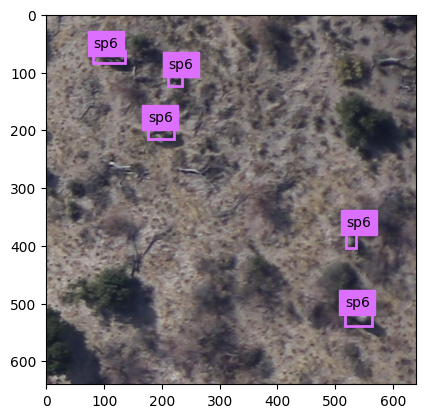

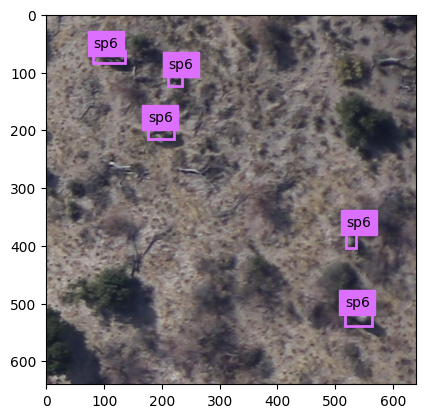

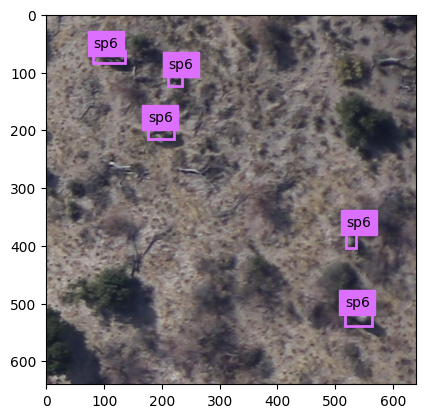

In [25]:
img_path = data['im_file']
label_path = Path(str(img_path).replace("images","labels")).with_suffix('.txt')
label_map = data_config['names']
visualize_image_annotations(data['im_file'],label_path,label_map)

In [ ]:
# Load a model
model_sam = SAM("sam2.1_l.pt")
model_sam.info()

In [ ]:
# Load model, does not work well
# model_fastsam = FastSAM("FastSAM-x.pt")
# model_fastsam.info()

In [47]:
# FastSAM
# bboxes = bboxes = torch.cat([data['bboxes'][:,:2], data['bboxes'][:,:2] + data['bboxes'][:,2:]],1) #data['bboxes']
# bboxes = (bboxes*640).long().tolist()
# print(bboxes)
# results_fastsam, = model_fastsam(img_path, device="cpu", bboxes=bboxes[0], imgsz=640, conf=0.4, iou=0.9)
# results_fastsam.show()

https://docs.ultralytics.com/models/sam-2/#sam-2-prediction-examples
- *Run inference with bboxes prompt* (xmin,ymin,xmax,ymax)
    ``results = model("path/to/image.jpg", bboxes=[100, 100, 200, 200]) ``

- *Run inference with single point*
    ``results = model(points=[900, 370], labels=[1])``

- *Run inference with multiple points*
    ``results = model(points=[[400, 370], [900, 370]], labels=[1, 1])``

- *Run inference with multiple points prompt per object*
    ``results = model(points=[[[400, 370], [900, 370]]], labels=[[1, 1]])``

- *Run inference with negative points prompt*
    ``results = model(points=[[[400, 370], [900, 370]]], labels=[[1, 0]])``

In [116]:
# Run inference with bboxes prompt
bboxes = torch.cat([data['bboxes'][:,:2], data['bboxes'][:,:2] + data['bboxes'][:,2:]],1)
bboxes = (bboxes*640).long().tolist()
print(bboxes)
results_sam, = model_sam(data['im_file'],
                imgsz=640,
                bboxes=bboxes,
                labels=data['cls'].long().tolist(),
                # points=targets['points'].tolist(), # list[(x,y)]
                save_dir=None)

[[527, 387, 544, 420], [540, 524, 587, 552], [198, 202, 243, 226], [108, 72, 163, 93], [222, 110, 245, 136]]

image 1/1 D:\general_dataset\tiled-data\val\images\12f37f170f1379682e15b749c79edb1e234330c9_18.JPG: 640x640 1 0, 1 1, 1 2, 1 3, 1 4, 2433.6ms
Speed: 12.3ms preprocess, 2433.6ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)


In [74]:
data['cls'].long().view(-1,1,1).shape

torch.Size([5, 1, 1])

In [70]:
results_sam.show()

In [71]:
results_sam.masks.data.shape

torch.Size([5, 640, 640])

In [81]:
mask = results_sam.masks.data * data['cls'].long().view(-1,1,1)
mask.shape

torch.Size([5, 640, 640])

In [86]:
mask[0].max()

tensor(5)

### convert masks into yolo segmentation format

In [122]:
import cv2
import numpy as np

def convert_segment_masks_to_yolo_seg(masks_sam2:np.ndarray, output_path:str, num_classes:int,verbose:bool=False):
    """Inspired by https://github.com/ultralytics/ultralytics/blob/main/ultralytics/data/converter.py#L350
    Converts a SAM2 segmentation mask to the YOLO segmentation format.

    """
    assert len(masks_sam2.shape)==3, "[b,h,w]"
    pixel_to_class_mapping = {i + 1: i for i in range(num_classes)}

    file = open(output_path, "w", encoding="utf-8")
    for i in range(masks_sam2.shape[0]):
        mask = masks_sam2[i]
        img_height, img_width = mask.shape  # Get image dimensions

        unique_values = np.unique(mask)  # Get unique pixel values representing different classes
        yolo_format_data = []

        for value in unique_values:
            if value == 0:
                continue  # Skip background
            class_index = pixel_to_class_mapping.get(value, -1)
            if class_index == -1:
                print(f"Unknown class for pixel value {value} in file {mask_path}, skipping.")
                continue

            # Create a binary mask for the current class and find contours
            contours, _ = cv2.findContours(
                (mask == value).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )  # Find contours

            for contour in contours:
                if len(contour) >= 3:  # YOLO requires at least 3 points for a valid segmentation
                    contour = contour.squeeze()  # Remove single-dimensional entries
                    yolo_format = [class_index]
                    for point in contour:
                        # Normalize the coordinates
                        yolo_format.append(round(point[0] / img_width, 6))  # Rounding to 6 decimal places
                        yolo_format.append(round(point[1] / img_height, 6))
                    yolo_format_data.append(yolo_format)

        # Save Ultralytics YOLO format data to file
        
        for item in yolo_format_data:
            line = " ".join(map(str, item))
            file.write(line + "\n")
    if verbose:
        print(f"Processed and stored at {output_path}.")
    file.close()

In [52]:
# Example: load Prediction images
with open(args.data_config_yaml, 'r') as file:
    data_config = yaml.load(file, Loader=yaml.FullLoader)
data_config

{'path': 'D:\\general_dataset\\tiled-data',
 'train': ['val\\images'],
 'val': ['val\\images'],
 'test': ['test\\images'],
 'nc': 6,
 'names': {0: 'sp1', 1: 'sp2', 2: 'sp3', 3: 'sp4', 4: 'sp5', 5: 'sp6'}}

In [123]:
tmp_file = "./example.txt"
convert_segment_masks_to_yolo_seg(masks_sam2=mask.cpu().numpy(), output_path=tmp_file, num_classes=data_config['nc'],verbose=True)

Processed and stored at ./example.txt.


In [ ]:
from pathlib import Path
from tqdm import tqdm
def create_yolo_seg_labels(data_config_yaml:str,imgsz:int,model_sam:SAM):

    with open(data_config_yaml, 'r') as file:
        data_config = yaml.load(file, Loader=yaml.FullLoader)

    
    splits=[s for s in ['val','train','test'] if s in data_config.keys()]

    print("Convertings splits:", splits)

    for split in splits:
        datasets = list()

        # Load YOLO dataset
        for path in data_config[split]:
            # create Segmentations directory inside split
            seg_labels_dir = (Path(path).parent/'Segmentations'/'labels')
            seg_labels_dir.mkdir(exist_ok=True,parents=True)
            (Path(path).parent/'Segmentations'/'images').mkdir(exist_ok=True,parents=True)
            images_path = os.path.join(data_config['path'], path)
            dataset = YOLODataset(img_path=images_path,task='detect',data={'names':data_config['names']},augment=False,imgsz=imgsz,classes=None)
            datasets.append(dataset)
        dataset = YOLOConcatDataset(datasets)

        #  Saving segmentations
        for data in tqdm(dataset,desc=f"Creating yolo-seg for splut={split}"):
            # Run inference with bboxes prompt
            bboxes = torch.cat([data['bboxes'][:,:2], data['bboxes'][:,:2] + data['bboxes'][:,2:]],1)
            bboxes = (bboxes*imgsz).long().tolist()
            results, = model_sam(data['im_file'],
                            imgsz=imgsz,
                            bboxes=bboxes,
                            labels=data['cls'].long().tolist(),
                            save_dir=None)
            # create masks
            mask = results.masks.data * data['cls'].long().view(-1,1,1)
            assert len(mask.shape)==3
            # convert masks to yolo-seg
            output_dir = Path(data['im_file']).parent.parent/'Segmentations'/'labels'
            output_path = output_dir / Path(data['im_file']).with_suffix(".txt").name
            convert_segment_masks_to_yolo_seg(masks_sam2=mask.cpu().numpy(), 
                                                output_path=output_path, 
                                                classes=data_config['nc'],
                                                verbose=False
                                            )
    

In [127]:
Path(data['im_file']).with_suffix(".txt").name

'12f37f170f1379682e15b749c79edb1e234330c9_18.txt'

In [128]:
Path(data['im_file']).parent.parent/'Segmentations'/'labels'

WindowsPath('D:/general_dataset/tiled-data/val/Segmentations/labels')

In [105]:
split='train'
images_path = [Path(os.path.join(data_config['path'], path)).glob('*') for path in data_config[split]]
images_path = chain.from_iterable(images_path)

# Optimizing inference params

In [ ]:
from datalabeling.annotator import Detector
from datalabeling.arguments import Arguments
from datalabeling.dataset.sampling import (get_preds_targets, compute_detector_performance, get_uncertainty)    
import yaml, os
from hyperopt import tpe, hp, fmin

In [ ]:
# params 
args = Arguments()
args.path_to_weights = r"C:/Users/Machine Learning/Desktop/workspace-wildAI/datalabeling/runs/mlflow/140168774036374062/57daf3bcd99b4dd4b040cb4f8670960c/artifacts/weights/best.pt"
# args.confidence_threshold = 0.2
# args.overlap_ratio = 0.1
args.use_sliding_window = True
args.device = "cuda"
args.is_yolo_obb = True
args.pred_results_dir = r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\.tmp"
args.data_config_yaml = r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_hn.yaml"
args.hn_uncertainty_method = "entropy"


In [ ]:
# load groundtruth
with open(args.data_config_yaml,'r') as file:
    yolo_config = yaml.load(file,Loader=yaml.FullLoader)

split='val'
images_path = [os.path.join(yolo_config['path'],yolo_config[split][i]) for i in range(len(yolo_config[split]))]
images_path

In [ ]:
def objective(params:dict):

    # Define detector
    model = Detector(path_to_weights=args.path_to_weights,
                        confidence_threshold=params['confidence_threshold'],
                        overlap_ratio=params['overlap_ratio'],
                        tilesize=params['tilesize'],
                        imgsz=params['imgsz'],
                        use_sliding_window=args.use_sliding_window,
                        device=args.device,
                        is_yolo_obb=args.is_yolo_obb
                    )

    df_results, df_labels, col_names = get_preds_targets(images_dirs=images_path,
                                                        pred_results_dir=args.pred_results_dir,
                                                        detector=model,
                                                        load_results=False,
                                                        save_tag=f"{params['imgsz']}-{params['tilesize']}-{params['overlap_ratio']}-{params['confidence_threshold']}"
                                                        )

    df_results_per_img = compute_detector_performance(df_results,df_labels,col_names)
    # df_results_per_img = get_uncertainty(df_results_per_img=df_results_per_img,mode=args.hn_uncertainty_method)

    # minizing loss -> maximize map50 and map75
    loss = -1.0*df_results_per_img["map50"].mean() - df_results_per_img["map75"].mean() #+ df_results_per_img["uncertainty"].mean()

    return loss

In [ ]:
search_space = {
                'confidence_threshold': hp.uniform('x', 0.1, 0.7),
                'overlap_ratio': hp.uniform('y', 0, 0.25),
                'tilesize': hp.choice(label='tilesize',options=[640, 2*640]),
                'imgsz': hp.choice(label='imgsz',options=[640, 2*640, 3*640, 4*640]),
            }

best = fmin(
    fn=objective, # Objective Function to optimize
    space=search_space, # Hyperparameter's Search Space
    algo=tpe.suggest, # Optimization algorithm (representative TPE)
    max_evals=2 # Number of optimization attempts
)

In [ ]:
print(best)

# Dataset label format conversion

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def check_label_format(loaded_df:pd.DataFrame)->str:
    """checks label format

    Args:
        loaded_df (pd.DataFrame): target values

    Raises:
        NotImplementedError: when the format is not yolo or yolo-obb

    Returns:
        str: yolo or yolo-obb
    """

    num_features = len(loaded_df.columns)

    if num_features == 5:
        return "yolo"
    elif num_features == 9:
        return "yolo-obb"
    else:
        raise NotImplementedError(f"The number of features ({num_features}) in the label file is wrong. Check yolo or yolo-obb format.")

In [ ]:
label_path = r"D:\PhD\Data per camp\DetectionDataset\Rep 1\train\labels\DJI_20231002150401_0009_0_48_0_1271_640_1911.txt"
df = pd.read_csv(label_path,sep=' ',header=None)
df

In [ ]:
isinstance(df.iloc[:,0].dtype, np.dtypes.IntDType)

In [ ]:
check_label_format(df)

In [ ]:
len(df.columns)

In [ ]:
df.columns = ['id','x1','y1','x2','y2','x3','y3','x4','y4']

df

# Debug

In [1]:
from ultralytics import YOLO
import yaml
from datalabeling.arguments import Arguments, Dataprepconfigs
import os, logging, traceback
from pathlib import Path
import pandas as pd
import math
import traceback

In [2]:
args = Dataprepconfigs()

args.empty_ratio = 15
args.parse_ls_config = True
args.label_map =  r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\exported_annotations\label_mapping.json" 
args.min_visibility = 0.7 
args.dest_path_labels =  r"D:\PhD\Data per camp\IdentificationDataset\val\labels"  
args.ls_json_dir =  r"D:\PhD\Data per camp\Exported annotations and labels\identification-splits\val\labelstudio" 
args.dest_path_images = r"D:\PhD\Data per camp\IdentificationDataset\val\images" 
args.coco_json_dir = r"D:\PhD\Data per camp\Exported annotations and labels\identification-splits\val\coco-format"
args.height = 800
args.width = 800
args.data_config_yaml =  r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification.yaml"
args.keep_labels = ("buffalo", "impala", "nyala", "nyala(m)", "roan", "sable")
args.discard_labels = None
args.save_all = False
args.clear_yolo_dir = False
args.save_only_empty = False
args.is_detector = False

args.load_coco_annotations = True

In [4]:
from datalabeling.dataset import  update_yolo_data_cfg, get_slices, sample_data, load_coco_annotations, load_label_map

if args.load_coco_annotations:
    map_imgdir_cocopath = load_coco_annotations(dest_dir_coco=args.coco_json_dir)

    # load label map
if not args.is_detector:
    label_map = load_label_map(path=args.label_map,
                                label_to_discard=args.discard_labels,
                                labels_to_keep=args.keep_labels)
    # update_yolo_data_cfg(args.data_config_yaml, label_map=label_map)
    name_id_map = {val:key for key,val in label_map.items()}

In [5]:
label_map

{0: 'buffalo', 1: 'impala', 2: 'nyala', 3: 'nyala(m)', 4: 'roan', 5: 'sable'}

In [6]:
       
# slice coco annotations and save tiles
for img_dir,cocopath in map_imgdir_cocopath.items():
    # try:
    # slice annotations
    coco_dict_slices = get_slices(coco_annotation_file_path=cocopath,
                        img_dir=img_dir,
                        slice_height=args.height,
                        slice_width=args.width,
                        overlap_height_ratio=args.overlap_ratio,
                        overlap_width_ratio=args.overlap_ratio,
                        min_area_ratio=args.min_visibility,
                        ignore_negative_samples= (args.empty_ratio<1e-8 and not args.save_all), # equivalent to args.empty_ratio == 0.0
                        )
    
    break
    # sample tiles
    df_tiles = sample_data(coco_dict_slices=coco_dict_slices,
                            empty_ratio=args.empty_ratio,
                            out_csv_path= None, #Path(args.dest_path_images).with_name("gt.csv"),
                            img_dir=img_dir,
                            save_all=args.save_all,
                            labels_to_discard=args.discard_labels,
                            labels_to_keep=args.keep_labels,
                            sample_only_empty=args.save_only_empty
                            )
    # except Exception as e:
    #     traceback.print_exc()
    

indexing coco dataset annotations...


100%|██████████| 1152/1152 [00:37<00:00, 31.02it/s]


In [7]:
def get_parent_image(file_name:str):
    ext = '.jpg' 
    file_name = Path(file_name).stem
    # print(file_name)
    parent_file = '_'.join(file_name.split('_')[:-5])
    p = os.path.join(img_dir,parent_file+ext)
    if os.path.exists(p):
        return p
    raise FileNotFoundError(f'Parent file note found for {file_name} in {img_dir} >> {parent_file}')
    
    
# build mapping for labels
label_ids = [cat['id'] for cat in coco_dict_slices['categories']]
label_name = [cat['name'] for cat in coco_dict_slices['categories']]
label_map = dict(zip(label_ids,label_name))

# build dataFrame of image slices 
ids = list()
x0s, x1s = list(), list()
y0s, y1s = list(), list()
file_paths = list()
parent_file_paths = list()
for metadata in coco_dict_slices['images']:
    # img_path = os.path.join(img_dir,metadata['file_name'])
    file_paths.append(metadata['file_name'])
    file_name = os.path.basename(metadata['file_name'])
    x_0,y_0,x_1,y_1 = file_name.split('.')[0].split('_')[-4:]
    parent_image = get_parent_image(file_name)
    break

In [11]:
metadata, img_dir

({'height': 800,
  'width': 800,
  'id': 1,
  'file_name': 'DJI_20231003094758_0001_0_0_0_0_800_800.jpg'},
 'D:\\PhD\\Data per camp\\Dry season\\Kapiri\\Camp 3\\Rep 1 - tiled')

In [ ]:
from ultralytics.data import YOLODataset
from datalabeling.arguments import Arguments
from ultralytics.data import build_dataloader
from tqdm import tqdm


# https://github.com/ultralytics/ultralytics/blob/main/ultralytics/data/dataset.py
# img_path (str): Path to the folder containing images.
# imgsz (int, optional): Image size. Defaults to 640.
# cache (bool, optional): Cache images to RAM or disk during training. Defaults to False.
# augment (bool, optional): If True, data augmentation is applied. Defaults to True.
# hyp (dict, optional): Hyperparameters to apply data augmentation. Defaults to None.
# prefix (str, optional): Prefix to print in log messages. Defaults to ''.
# rect (bool, optional): If True, rectangular training is used. Defaults to False.
# batch_size (int, optional): Size of batches. Defaults to None.
# stride (int, optional): Stride. Defaults to 32.
# pad (float, optional): Padding. Defaults to 0.0.
# single_cls (bool, optional): If True, single class training is used. Defaults to False.
# classes (list): List of included classes. Default is None.
# fraction (float): Fraction of dataset to utilize. Default is 1.0 (use all data).

In [ ]:
args = Arguments()
args.data_config_yaml = r"D:\datalabeling\data\data_config.yaml"

with open(args.data_config_yaml, 'r') as file:
    data_config = yaml.load(file, Loader=yaml.FullLoader)

kwargs = dict(img_path=os.path.join(data_config['path'],data_config['val'][0]),
              data=data_config,
              task='detect',
              imgsz=800,
              cache=None,
              augment=False,
              hyp=None,
              batch_size=8,
              single_cls=False,
              rect=False,
              prefix='debug',
              stride=1,
              pad=0.,
              classes=None,
              fraction=1.0
              )

In [16]:
dataset = YOLODataset(**kwargs)

Scanning D:\general_dataset\tiled-data\test\labels... 1356 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1356/1356 [00:02<00:00, 617.24it/s]

New cache created: D:\general_dataset\tiled-data\test\labels.cache


In [ ]:
dataset[0]

In [36]:
dataloader = build_dataloader(dataset=dataset,batch=8,workers=8,shuffle=False)

In [48]:
batch = next(iter(dataloader))

In [ ]:
batch.keys()

In [ ]:
batch['im_file']

In [ ]:
batch['ori_shape']

In [ ]:
batch['img'].flip(1).shape

In [ ]:
batch['img'].min(),batch['img'].max()

In [ ]:
batch['img'].shape, batch['bboxes'].shape, batch['cls'].shape

In [ ]:
batch['bboxes']